In [8]:
import transformers
print(transformers.__file__)

C:\Users\Abraham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\transformers\__init__.py


In [1]:
#########################################################################
# 1. Setup and Imports
#########################################################################

# --- Core utilities ---
import os
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from IPython.display import display

# --- Hugging Face libraries ---
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModelForSeq2SeqLM,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)

# --- Metrics ---
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# --- Environment setup ---
warnings.filterwarnings("ignore")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using device: {device}")
print(f"🧠 Torch version: {torch.__version__}")

✅ Using device: cpu
🧠 Torch version: 2.7.1+cpu


In [2]:
#########################################################################
# 2. Load and Explore the Dataset
#########################################################################
train_df = pd.read_csv(
    "C:/Users/Abraham/Documents/Dell/DSTI/19- Deep learning/Project/Datasets/step1-2_cleaned_data.csv"
)
val_df = pd.read_csv(
    "C:/Users/Abraham/Documents/Dell/DSTI/19- Deep learning/Project/Datasets/step1-2_cleaned_validation.csv"
)

print(f"✅ Training data shape: {train_df.shape}")
print(f"✅ Validation data shape: {val_df.shape}")
print("Training sentiment distribution:")
print(train_df["sentiment"].value_counts())

# Remove previous column names

train_df = train_df.iloc[1:].reset_index(drop=True)
val_df = val_df.iloc[1:].reset_index(drop=True)

# Preview
print("\n🔹 Training set preview:")
display(train_df.head())

print("\n🔹 Validation set preview:")
display(val_df.head())

✅ Training data shape: (50371, 4)
✅ Validation data shape: (824, 4)
Training sentiment distribution:
sentiment
Positive    18548
Negative    16345
Neutral     15478
Name: count, dtype: int64

🔹 Training set preview:


,id,topic,sentiment,tweet
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...



🔹 Validation set preview:


,id,topic,sentiment,tweet
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


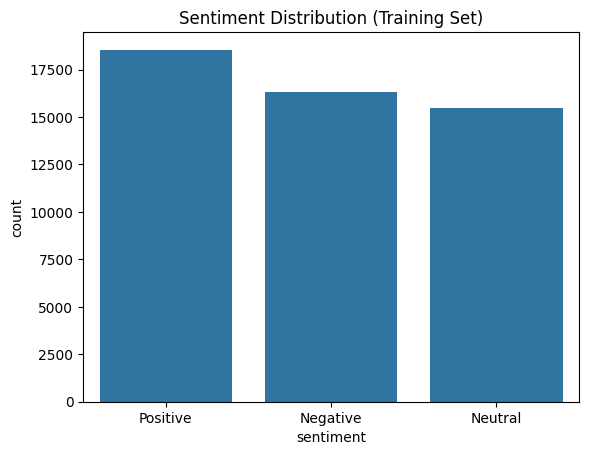

In [3]:
# Check class distribution
sns.countplot(x="sentiment", data=train_df, order=train_df["sentiment"].value_counts().index)
plt.title("Sentiment Distribution (Training Set)")
plt.show()

In [4]:
#########################################################################
# 3. Preprocessing
#########################################################################

# 1️⃣ Rename columns for consistency
train_df = train_df.rename(columns={"tweet": "text", "sentiment": "Sentiment"})
val_df   = val_df.rename(columns={"tweet": "text", "sentiment": "Sentiment"})

# 2️⃣ Map 3 sentiment classes to numeric labels
label_map = {label: i for i, label in enumerate(sorted(train_df["Sentiment"].unique()))}
train_df["label"] = train_df["Sentiment"].map(label_map)
val_df["label"]   = val_df["Sentiment"].map(label_map)

print("✅ Label mapping:", label_map)
print("✅ Sentiments present:", train_df["Sentiment"].unique())

# 3️⃣ Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[["text", "label"]])
val_dataset   = Dataset.from_pandas(val_df[["text", "label"]])


✅ Label mapping: {'Negative': 0, 'Neutral': 1, 'Positive': 2}
✅ Sentiments present: ['Positive' 'Neutral' 'Negative']


In [5]:
#########################################################################
# 4. Fine-tuning Functions
#########################################################################

def train_and_evaluate_encoder(model_name):
    """Fine-tune encoder-only models (BERT, RoBERTa, DeBERTa...)"""
    print(f"\n🚀 Fine-tuning (Encoder-only): {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # --- Tokenization ---
    def tokenize_fn(examples):
        texts = list(examples["text"])
        return tokenizer(texts, truncation=True, padding=True, max_length=128)

    tokenized_train = train_dataset.map(tokenize_fn, batched=True)
    tokenized_val = val_dataset.map(tokenize_fn, batched=True)

    # --- Model setup ---
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_map)).to(device)
    
    # 🔒 Freeze most layers and unfreeze last 2–4 layers
    for name, param in model.base_model.named_parameters():
        param.requires_grad = False  # freeze all first
    for name, param in model.base_model.encoder.layer[-2:].named_parameters():
        param.requires_grad = True  # unfreeze last 2 layers

    # --- Metrics (no AUC) ---
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=1)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
        acc = accuracy_score(labels, preds)
        return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

    # --- Training arguments ---
    args = TrainingArguments(
        output_dir=f"./results/{model_name.split('/')[-1]}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=5,  # ⏫ increased to 5
        weight_decay=0.01,
        logging_dir='./logs',
        load_best_model_at_end=True
    )

    # --- Data collator for efficient padding ---
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # --- Trainer with Early Stopping ---
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
        data_collator=data_collator,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # ⏸️ stop if 2 bad epochs
    )

    trainer.train()
    results = trainer.evaluate()
    return model, tokenizer, results


def train_and_evaluate_encoder_decoder(model_name):
    """Fine-tune encoder-decoder models (T5, BART...)"""
    print(f"\n🚀 Fine-tuning (Encoder-Decoder): {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

    # Convert numeric labels back to text
    id2label = {v: k for k, v in label_map.items()}
    train_df["target_text"] = train_df["label"].map(id2label)
    val_df["target_text"] = val_df["label"].map(id2label)

    train_df["formatted_input"] = "tweet: " + train_df["text"] + " sentiment:"
    val_df["formatted_input"] = "tweet: " + val_df["text"] + " sentiment:"


    train_dataset_t5 = Dataset.from_pandas(train_df[["formatted_input", "target_text"]])
    val_dataset_t5 = Dataset.from_pandas(val_df[["formatted_input", "target_text"]])

    def preprocess_fn(batch):
        model_inputs = tokenizer(batch["formatted_input"], padding="max_length", truncation=True, max_length=128)
        with tokenizer.as_target_tokenizer():
            labels = tokenizer(batch["target_text"], padding="max_length", truncation=True, max_length=10)
        model_inputs["labels"] = labels["input_ids"]
        return model_inputs

    tokenized_train = train_dataset_t5.map(preprocess_fn, batched=True)
    tokenized_val = val_dataset_t5.map(preprocess_fn, batched=True)
    
    args = TrainingArguments(
    output_dir=f"./results/{model_name.split('/')[-1]}",
    eval_strategy="epoch",           # ✅ renamed parameter
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True
    )


    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer
    )

    trainer.train()

    # Simple accuracy evaluation on a sample
    preds, refs = [], []
    for sample in val_df.sample(min(100, len(val_df))).itertuples():
        input_ids = tokenizer("tweet: " + sample._1 + " sentiment:", return_tensors="pt").input_ids.to(device)
        outputs = model.generate(input_ids, max_length=10)
        preds.append(tokenizer.decode(outputs[0], skip_special_tokens=True))
        refs.append(sample.target_text)

    acc = accuracy_score(refs, preds)
    return model, tokenizer, {"accuracy": acc}

In [ ]:
#########################################################################
# 5. Fine-tune 4 Models (2 Encoder-only + 2 Encoder-decoder)
#########################################################################

models_encoder = {
    "RoBERTa-base": "roberta-base",
    "DeBERTa-v3-base": "microsoft/deberta-v3-base"
}

models_encoder_decoder = {
    "T5-small": "t5-small",
    "BART-base": "facebook/bart-base"
}

results_dict = {}

# Fine-tune encoder-only models
for name, model_name in models_encoder.items():
    start = time.time()
    model, tokenizer, results = train_and_evaluate_encoder(model_name)
    results["inference_time_sec"] = time.time() - start
    results_dict[name] = results
    print(f"\n{name} Results:", results)

# Fine-tune encoder-decoder models
for name, model_name in models_encoder_decoder.items():
    start = time.time()
    model, tokenizer, results = train_and_evaluate_encoder_decoder(model_name)
    results["inference_time_sec"] = time.time() - start
    results_dict[name] = results
    print(f"\n{name} Results:", results)



🚀 Fine-tuning (Encoder-only): roberta-base


Map:   0%|          | 0/50370 [00:00<?, ? examples/s]

Map:   0%|          | 0/823 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.665900,0.520519,0.791009,0.795494,0.791009,0.789143
2,0.521400,0.376630,0.849332,0.850208,0.849332,0.848776


In [19]:
#########################################################################
# 6. Compare Model Performance
#########################################################################

results_df = pd.DataFrame(results_dict).T
display(results_df[["accuracy", "f1", "precision", "recall", "inference_time_sec"]].fillna("-"))

# Plot accuracy comparison
plt.figure(figsize=(8,4))
sns.barplot(x=results_df.index, y=results_df["accuracy"])
plt.title("Accuracy Comparison Across Models")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()


NameError: name 'results_dict' is not defined